<a href="https://colab.research.google.com/github/sanyamChaudhary27/ML_models_from_scratch/blob/main/DecisionTreeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

In [ ]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    def is_leaf_node(self):
        return self.value is not None

In [ ]:
from collections import Counter
import numpy as np

class DecisionTreeClassifier:
    def __init__(self, min_samples_split:int = 2, max_depth: int=100, criterion: str="gini", n_features=None):
        self.n_features = n_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_samples < self.min_samples_split or n_labels == 1):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best_feat, best_thresh = self._best_split(X, y, feat_idxs)

        if best_feat is None: # If no good split found, make it a leaf node
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0: # If a split results in an empty child node, make current node a leaf
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)

        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for thr in thresholds:
                gain = self._information_gain(y, X_column, thr)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = thr
        return split_idx, split_thresh

    def _calculate_impurity(self, y):
        if self.criterion == "gini":
            return self._gini(y)
        elif self.criterion == "entropy":
            return self._entropy(y)
        else:
            raise ValueError(f"Unknown criterion: {self.criterion}")

    def _information_gain(self, y, X_column, threshold):
        parent_impurity = self._calculate_impurity(y)
        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs)==0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        imp_l, imp_r = self._calculate_impurity(y[left_idxs]), self._calculate_impurity(y[right_idxs])
        child_impurity = (n_l/n) * imp_l + (n_r/n) * imp_r

        return parent_impurity-child_impurity

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p*np.log2(p) for p in ps if p>0])

    def _gini(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        gini = 1 - np.sum([p**2 for p in ps])
        return gini

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0] if counter else None
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, X, node):
        if node.is_leaf_node():
            return node.value
        if X[node.feature] <= node.threshold:
            return self._traverse_tree(X, node.left)
        return self._traverse_tree(X, node.right)

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [ ]:
data = datasets.load_breast_cancer()

In [ ]:
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [ ]:
X, y = data.data, data.target

<Axes: >

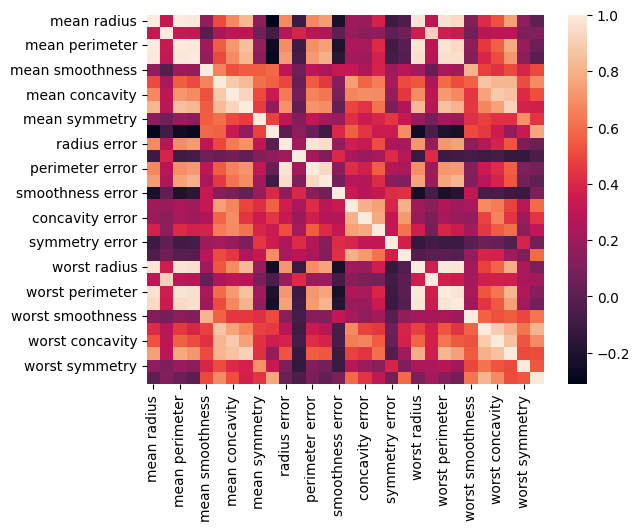

In [ ]:
df = pd.DataFrame(data.data, columns=data.feature_names)
cors = df.corr()
sns.heatmap(cors)

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [ ]:
clf = DecisionTreeClassifier(max_depth=5, criterion="entropy")
clf.fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)

In [ ]:
accuracy = np.sum(y_test == predictions) / len(y_test)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 93.86%


## Conclusion: Custom Decision Tree Classifier

This notebook demonstrates the implementation of a **Decision Tree Classifier from scratch**, serving as a foundational example for machine learning models built without relying on high-level libraries like scikit-learn for the core algorithm.

**Key steps and achievements include:**

1.  **`Node` Class Implementation**: A basic `Node` class was created to represent individual nodes within the decision tree structure, supporting both internal (split) nodes and leaf nodes.
2.  **`DecisionTreeClassifier` Class**: The main classifier class was built, encapsulating the entire decision tree logic.
3.  **Recursive Tree Growing (`_grow_tree`)**: An algorithm was implemented to recursively build the tree, handling various stopping conditions such as maximum depth, minimum samples for splitting, and pure nodes.
4.  **Best Split Selection (`_best_split`)**: The model includes logic to find the optimal feature and threshold for splitting, based on maximizing information gain.
5.  **Impurity Measures**: Both **Entropy** and **Gini Impurity** calculations were implemented (`_entropy`, `_gini`, `_calculate_impurity`) to quantify the homogeneity of node samples, allowing the user to choose the splitting criterion.
6.  **Prediction Mechanism (`predict`, `_traverse_tree`)**: Methods for traversing the trained tree and making predictions on new data points were developed.
7.  **Breast Cancer Dataset**: The custom classifier was applied to the `Breast Cancer Wisconsin (Diagnostic) Dataset` from `sklearn.datasets`.
8.  **Model Training and Evaluation**: The model was trained on the dataset, and its accuracy was evaluated, demonstrating its functionality.

This notebook serves as a robust example of how a fundamental classification algorithm like the Decision Tree can be constructed from its basic principles, providing valuable insight into its internal workings for educational or demonstration purposes within an `ml_models_from_scratch` repository.